# Stochastic Calculus: Simulating Price Dynamics

Simulations of stocks and options are often modeled using stochastic differential equations (SDEs). Because of the randomness associated with stock price movements, the SDEs cannot be developed by using ordinary differential equations (ODEs).

A typical model of a stock price is the following SDE:

$dS = \mu Sdt + \sigma SdW_{t} \ni$

$S$ = stock price \
$\mu$ = drift coefficient \
$\sigma$ = diffusion coefficient \
$W_{t}$ = a Wiener process

Each Wiener increment $W_{t}$ is computed by $W_{i} = z_{i}\sqrt{\Delta t_{i}}$

The cumulative sum of the Wiener increments, then, is the discretized Wiener path:

$W_{n}(t) = \sum_{i=1}^{n}W_{i}(t)$

Given that $S(0) = S_{0}$, the closed-form solution of geometric Brownian motion can then be given by:

$S(t) = S_{0}e^{(\mu - \dfrac{1}{2}\sigma^{2})t+\sigma W_{t}}$

### The Euler-Maruyama Approximation.

In order for us to know if we can correctly apply a mathematical model against a more complex model, we will need to examine the results of a numerical approximation against a simplified model with a known solution.

The previous example is a simple case where there exists a closed-form solution. However, not all models are like this.

For example, the Langevin equation, a stochastic gradient descent formula used to model interest rates, does not have a closed-form solution:

$dS = -\mu Sdt + \sigma dW_{t}$

In this case, we will have to approximate the solution. One of the most straightforward numerical methods is the Euler-Maruyama approximation, which is given by:

$w_{i+1} = w_{i} - \mu w_{i}\Delta t_{i} + \sigma\Delta W_{i}$

The approximation of the previous SDE is given by:

$w_{i+1} = w_{i} + \mu w_{i}\Delta t_{i} + \sigma w_{i}\Delta W_{i}$

In [6]:
def EulerMaruyama(So, mu, sigma, b, T, N, M):
    dt = M * (1 / N) # Step size.
    L = N / M
    wi = [So]
    for i in range(0, int(L)):
        Winc = np.sum(b[(M*(i-1)+M):(M*i + M)])
        w_i_new = wi[i]+mu*wi[i]*dt+sigma*wi[i]*Winc
        wi.append(w_i_new)
    return wi, dt

### Brownian motion.

The following are from the above formulae:

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import trange, tqdm

In [8]:
seed = 5       
N  = 2.**6 # Number of increments

In [9]:
def Brownian(seed, N):
    np.random.seed(seed)                         
    dt = 1./N # time step
    b = np.random.normal(0., 1., int(N))*np.sqrt(dt) # Brownian increments
    W = np.cumsum(b) # Brownian path
    return W, b

In [10]:
# Brownian increments
b = Brownian(seed, N)[1]

# Brownian motion
W = Brownian(seed, N)[0]
W = np.insert(W, 0, 0.) # W_0 = 0 for Brownian motion

If we plot the Brownian increments, we can see that the numbers oscillate like white noise, while the plot of the Brownian motion resembles a price time-series:

Text(0.5, 1.0, 'Brownian increments')

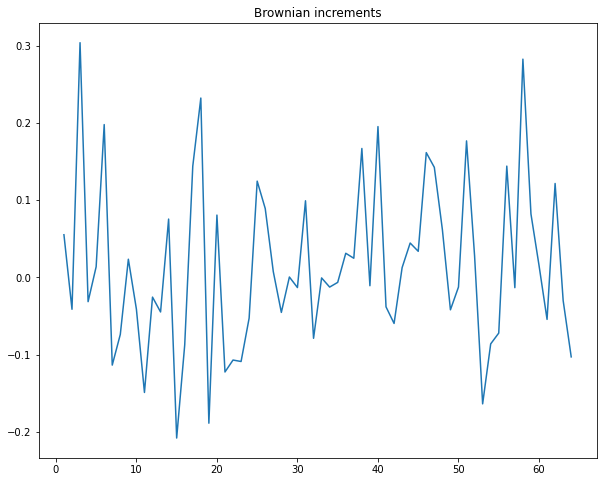

In [11]:
# Brownian increments
plt.rcParams['figure.figsize'] = (10,8)
xb = np.linspace(1, len(b), len(b))
plt.plot(xb, b)
plt.title('Brownian increments')

Text(0.5, 1.0, 'Brownian motion of AAPL closing prices')

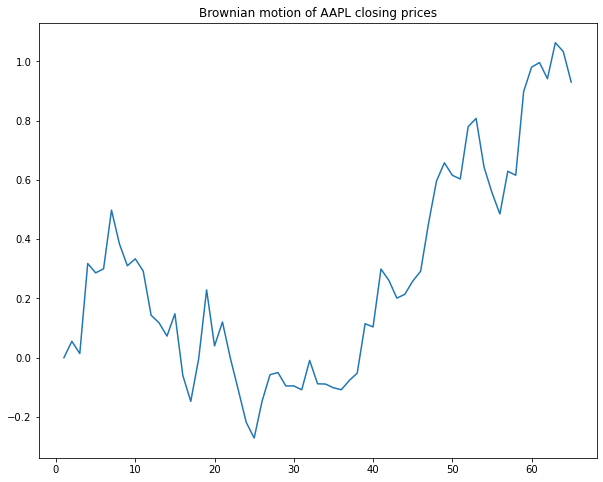

In [12]:
# Graph Brownian motion.
xw = np.linspace(1, len(W), len(W))
plt.plot(xw, W)
plt.title('Brownian motion of AAPL closing prices')

### Geometric Brownian motion.

Now that have successfully modeled Brownian motion, we can put the pieces together by modeling the closed-form solution of geometric Brownian motion:

$S(t) = S_{0}e^{(\mu = \dfrac{1}{2}\sigma^2)t+\sigma W_{t}}$

We will start using arbitrary returns and measure of volatility: 

In [13]:
def GeometricBrownianMotion(So, mu, sigma, W, T, N):    
    t = np.linspace(0.,1.,N+1)
    S = []
    S.append(So)
    for i in range(1,int(N+1)):
        drift = (mu - 0.5 * sigma**2) * t[i]
        diffusion = sigma * W[i-1]
        S_temp = So*np.exp(drift + diffusion)
        S.append(S_temp)
    return S, t

In [14]:
# Arbitrary parameters.
So = 55.25
mu = 0.15
sigma = 0.4
W = Brownian(seed, N)[0]
T = 1.
N = 2**6

result = GeometricBrownianMotion(So, mu, sigma, W, T, N)[0]
t = GeometricBrownianMotion(So, mu, sigma, W, T, N)[1]

Text(0.5, 1.0, 'Geometric Brownian Motion')

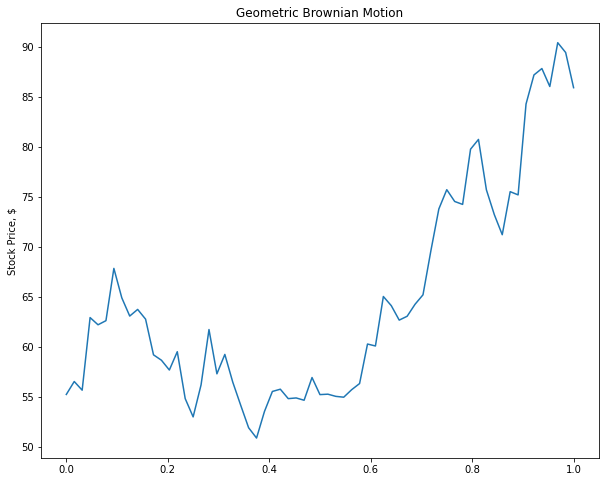

In [15]:
# Graph geometric Brownian motion.
plt.plot(t, result)
plt.ylabel('Stock Price, $')
plt.title('Geometric Brownian Motion')

We can interpret the x-axis as one full trading year, which is about $252$ trading days.

It is important to keep in mind that is a random walk; if the seed altered at all, the resulting shape will be completely different.

It is also important to note the limitations of this model: returns and volatility are kept constant, when in reality they are better modeled as stochastic processes.

Perhaps the most glaring weakness, however, is that the model fails to account for the possibility of severe shock.

In [16]:
def DailyReturn(adj_close):
    returns = []
    for i in range(0, len(adj_close)-1):
        today = adj_close[i+1]
        yesterday = adj_close[i]
        daily_return = (today - yesterday) / yesterday
        returns.append(daily_return)
    return returns

Let's try using the adjusted daily returns of a security to build a geometric Brownian motion model. We'll then take a look at a number of different random walks and compare them to the actual values to highlight just how difficult it is to predict price movement.

We will conclude with an implementation of the Euler-Maruyama approximation.

In [17]:
# Read data from file.
df = pd.read_csv('./../data/clean/aapl-adjusted-daily-compact.csv')
df.head()

,timestamp,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient
0,2020-05-26,323.50,324.24,316.50,316.73,79.0367,31380454,0.0,1.0
1,2020-05-27,316.14,318.71,313.09,318.11,79.3810,28236274,0.0,1.0
2,2020-05-28,316.77,323.44,315.63,318.25,79.4160,33449103,0.0,1.0
3,2020-05-29,319.25,321.15,316.47,317.94,79.3386,38399532,0.0,1.0
4,2020-06-01,317.75,322.35,317.21,321.85,80.3143,20254653,0.0,1.0


In [18]:
# Calculate the drift and diffusion coefficients.
adj_close = df['adjusted_close']
returns = DailyReturn(adj_close)

# There are approximately 252 trading days in a year.
mu = np.mean(returns) * 252
sigma = np.std(returns) * np.sqrt(252.)

mu, sigma

(1.174341310340022, 0.41015789283604476)

In [19]:
# Enter a value to search for and divide by.
value = 200.10

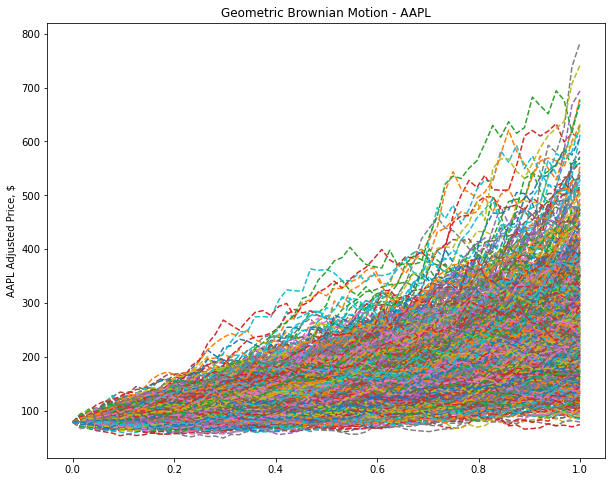

In [20]:
T = 1.
N = 2**6
So = adj_close[0]
walks = 1000

time = np.linspace(1, len(adj_close), len(adj_close))
time = [i/252. for i in time]

plt.plot(time, adj_close, label='Actual')

seeds = np.linspace(0, 100000, walks).astype(int)
results = []

for seed in seeds:
    W = Brownian(seed, N)[0]
    result = GeometricBrownianMotion(So, mu, sigma, W, T, N)[0]
    
    plt.plot(t, result, label='GBM (seed = {})'.format(seed), ls='--')

    plt.ylabel('AAPL Adjusted Price, $')
    plt.title('Geometric Brownian Motion - AAPL')
    # plt.legend(loc='upper left')
    
    results.append(result[-1])

In [21]:
!pip install ray

In [25]:
import ray
ray.shutdown()
ray.init()

2020-10-28 21:31:51,022	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '10.0.0.132',
 'raylet_ip_address': '10.0.0.132',
 'redis_address': '10.0.0.132:6379',
 'object_store_address': '/tmp/ray/session_2020-10-28_21-31-50_625275_940/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-10-28_21-31-50_625275_940/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2020-10-28_21-31-50_625275_940',
 'metrics_export_port': 64687}

TypeError: too many positional arguments

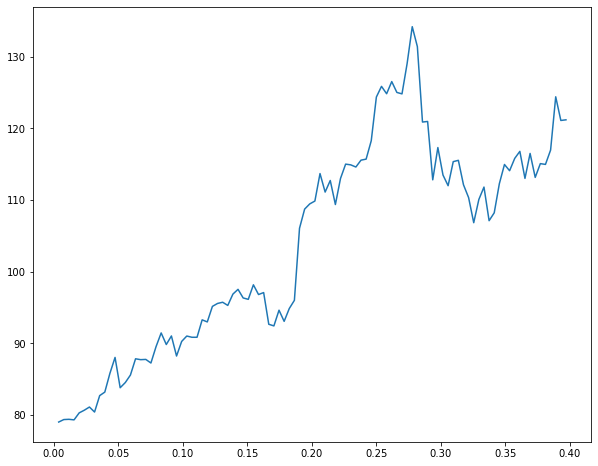

In [26]:
%%timeit
T = 1.
N = 2**6
So = adj_close[0]
walks = 1000

time = np.linspace(1, len(adj_close), len(adj_close))
time = [i/252. for i in time]

plt.plot(time, adj_close, label='Actual')

seeds = np.linspace(0, 100000, walks).astype(int)
results = []

@ray.remote
def iteration():
    for seed in seeds:
        W = Brownian(seed, N)[0]
        result = GeometricBrownianMotion(So, mu, sigma, W, T, N)[0]

        plt.plot(t, result, label='GBM (seed = {})'.format(seed), ls='--')

        plt.ylabel('AAPL Adjusted Price, $')
        plt.title('Geometric Brownian Motion - AAPL')
        # plt.legend(loc='upper left')

        results.append(result[-1])

futures = [iteration.remote(i) for i in range(4)]
print(ray.get(futures))

In [ ]:
under = len([i for i in results if i < value]) / walks * 100
over = len([i for i in results if i > value]) / walks * 100

print ('Probability of price being over ${} is {}%'.format(value, over))
print ('Probability price being under ${} is {}%'.format(value, under))

Testing against a large number of these simulations shows how well our model is able to generalize. If we were to fit a model on any one single random walk, we would almost assuredly overfit our model.

Now that we have some working geometric Brownian motion models, we can build an Euler-Maruyama model to approximate the path:

In [ ]:
b = Brownian(5, N)[1] # Brownian increments.

approximation = GeometricBrownianMotion(So, mu, sigma, W, T, N)[0]
time = GeometricBrownianMotion(So, mu, sigma, W, T, N)[1]
plt.plot(t, result, label='GBM')

# Trying out different time steps.
for M in [1, 4, 9, 16]:
    L = N/M
    EM_approximation = EulerMaruyama(So, mu, sigma, b, T, N, M)[0]
    EM_time = time_EM1 = np.linspace(0,1,int(L+1))
    plt.plot(EM_time, EM_approximation, label='dt = {}'.format(EM_approximation[1]), ls='--')

plt.ylabel('AAPL Adjusted Price, $')
plt.title('Geometric Brownian Motion - AAPL')

plt.legend(loc = 'upper left')